In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('microsoft.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060055,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062199,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063272,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061663,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060591,47894400


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9632 entries, 0 to 9631
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9632 non-null   object 
 1   Open       9632 non-null   float64
 2   High       9632 non-null   float64
 3   Low        9632 non-null   float64
 4   Close      9632 non-null   float64
 5   Adj Close  9632 non-null   float64
 6   Volume     9632 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 526.9+ KB


In [4]:
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

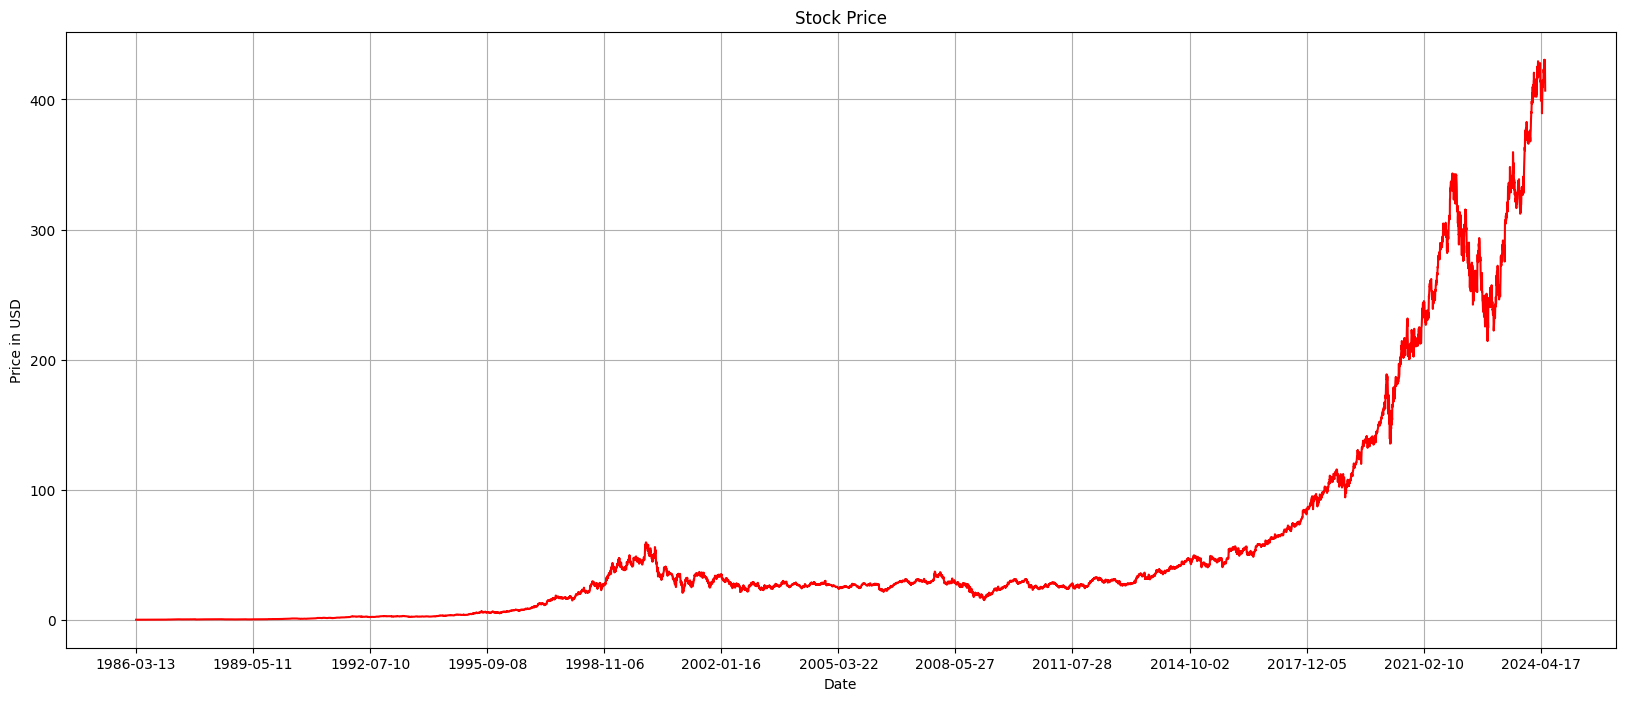

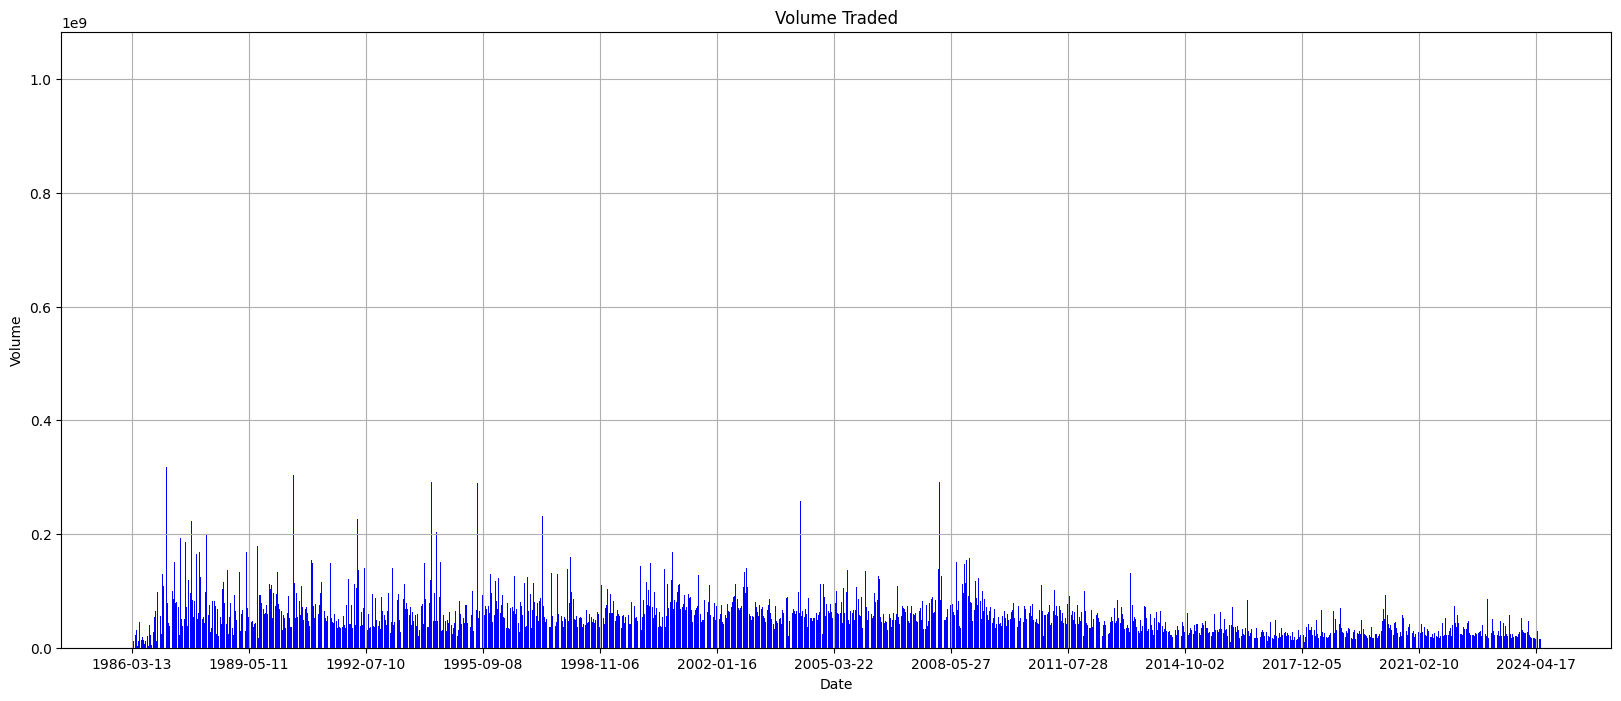

In [5]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(data['Date'], data['Close'], color='red')
ax.xaxis.set_major_locator(plt.MaxNLocator(15))
plt.title('Stock Price')
ax.set_xlabel('Date')
ax.set_ylabel('Price in USD')
plt.grid()
plt.show()

fig2, ax= plt.subplots(figsize=(20,8))
ax.bar(data['Date'], data['Volume'], color='blue')
ax.xaxis.set_major_locator(plt.MaxNLocator(15))
plt.title('Volume Traded')
ax.set_xlabel('Date')
ax.set_ylabel('Volume')
plt.grid()
plt.show()

In [6]:
data['parkinson'] = (1 / (4 * np.log(2))) * (np.log(data['High'] / data['Low']) ** 2)
parkinson_volatility = np.sqrt(data['parkinson'].mean())
print(f"Daily parkinson volatility: {parkinson_volatility}")
print(f"Annual parkinson volatility: {parkinson_volatility*np.sqrt(252)}")

Daily parkinson volatility: 0.017779040003246035
Annual parkinson volatility: 0.282233510388348


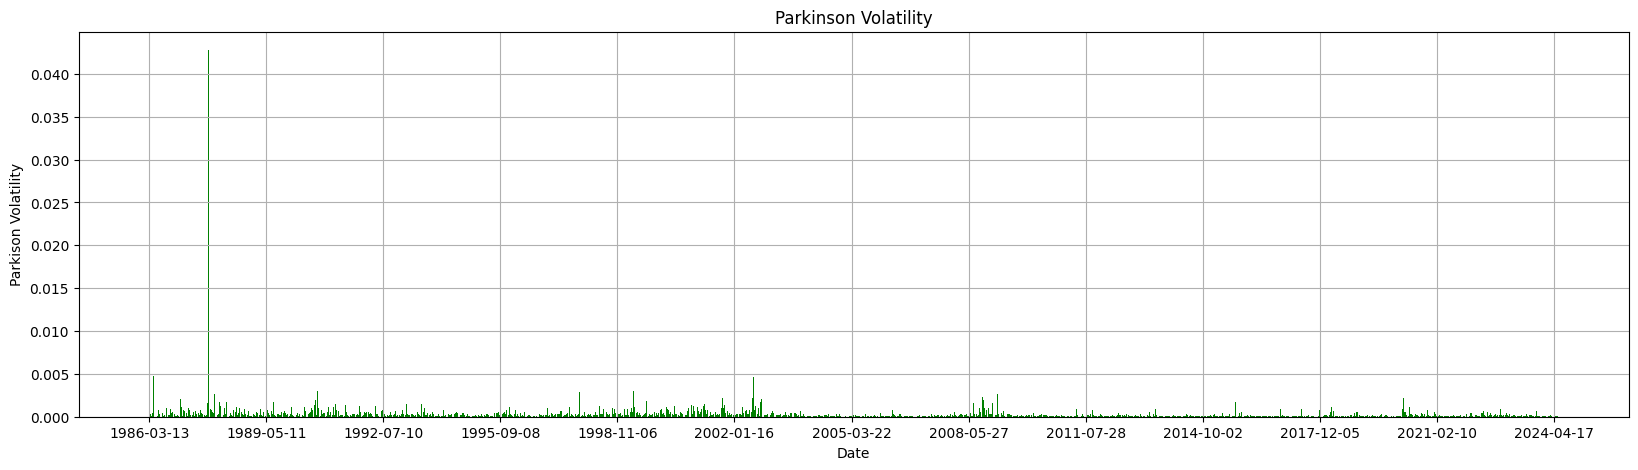

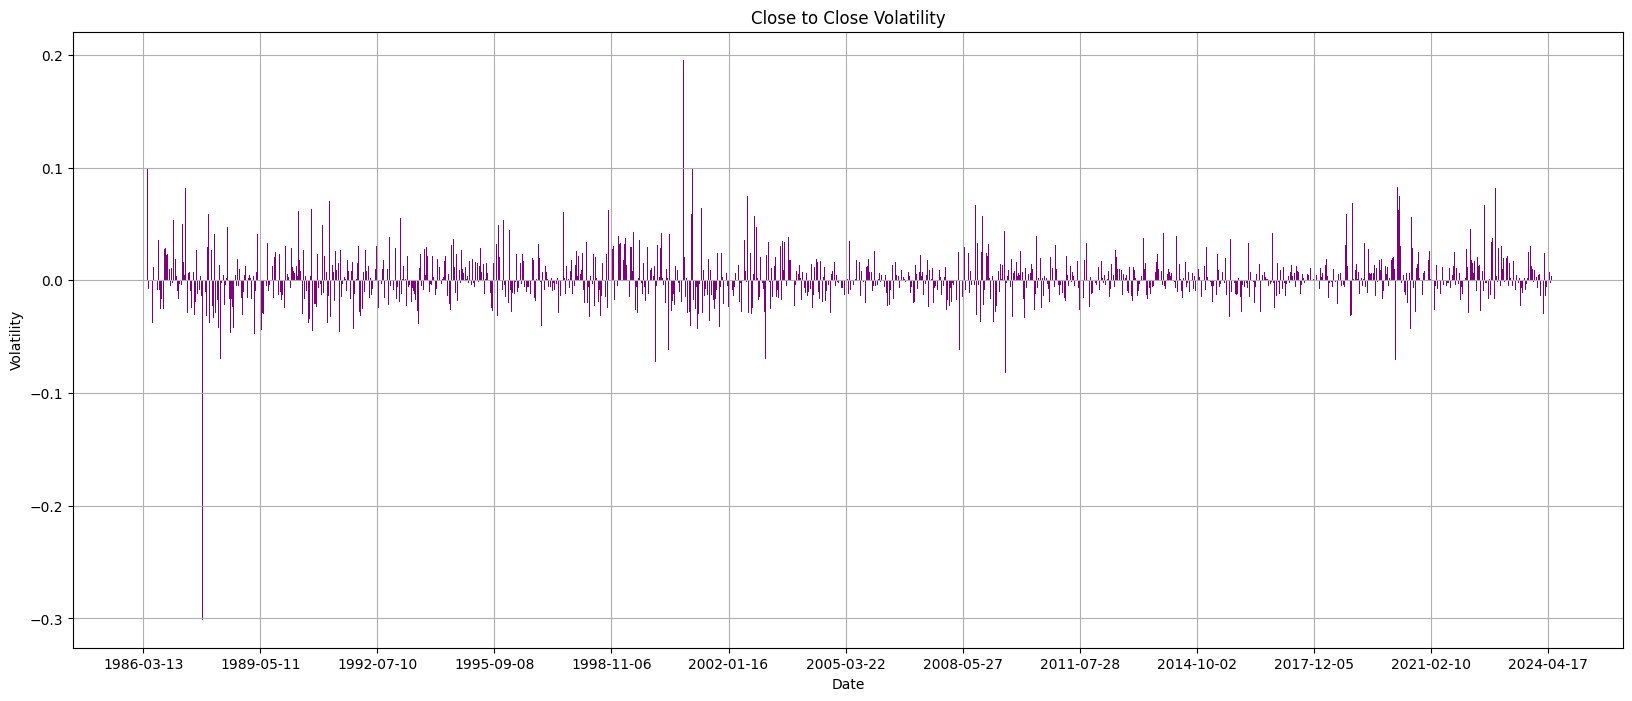

In [7]:
fig, ax = plt.subplots(figsize=(20,5))
ax.bar(data['Date'], data['parkinson'], color='green')
ax.xaxis.set_major_locator(plt.MaxNLocator(15))
ax.set_xlabel('Date')
ax.set_ylabel('Parkison Volatility')
plt.title('Parkinson Volatility')
plt.grid()
plt.show()


data['vol'] = data['Close'].pct_change().dropna()
fig2, ax = plt.subplots(figsize=(20,8))
ax.bar(data['Date'], data['vol'], color='purple')
ax.xaxis.set_major_locator(plt.MaxNLocator(15))
ax.set_xlabel('Date')
ax.set_ylabel('Volatility')
plt.title('Close to Close Volatility')
plt.grid()
plt.show()


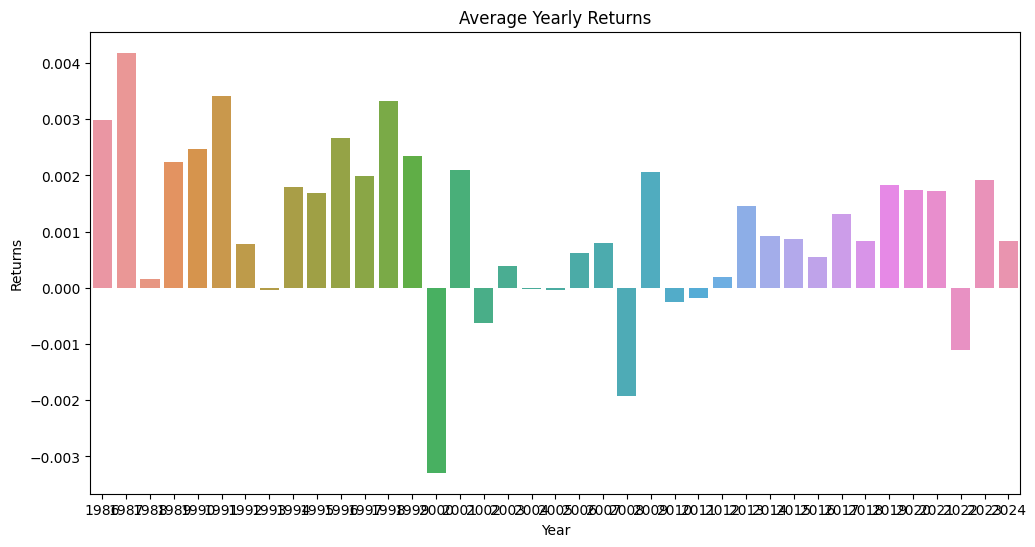

In [8]:
data["Date"] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year

yearly_returns = data.groupby(['Year'])['vol'].mean().reset_index()
yearly_returns = yearly_returns.sort_values('Year')

plt.figure(figsize=(12, 6))
sns.barplot(data=yearly_returns, x='Year', y='vol')
plt.title('Average Yearly Returns')
plt.xlabel('Year')
plt.ylabel('Returns')
plt.show()

In [9]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,parkinson,vol,Year
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060055,1031788800,0.006789,NaN,1986
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062199,308160000,0.000982,0.035712,1986
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063272,133171200,0.000235,0.017250,1986
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061663,67766400,0.000665,-0.025432,1986
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060591,47894400,0.000444,-0.017390,1986


In [10]:
data = data.iloc[:, 1:4]

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)
data = scaled_data

train_size = int(len(data) * 0.8)
data_train = data[:train_size]
data_test = data[train_size:]

In [12]:
x_train = []
y_train = []

timesteps = 60

for i in range(timesteps, len(data_train)):
    x_train.append(data_train[i-timesteps:i])
    y_train.append(data_train[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1], 3))

In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 3)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))


model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')


In [14]:
model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 2.3072e-04 - val_loss: 1.3452e-05
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 2.1849e-05 - val_loss: 7.4961e-06
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 1.8684e-05 - val_loss: 6.9933e-06
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 1.5256e-05 - val_loss: 6.5122e-06
Epoch 5/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 1.4447e-05 - val_loss: 2.2095e-05
Epoch 6/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 1.5535e-05 - val_loss: 2.2669e-05
Epoch 7/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 1.3449e-05 - val_loss: 7.3977e-06
Epoch 8/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 1.3147e-05 - val_loss: 6.8028e-06
Epoch 9/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 1.1980e-05 - val_loss: 7.1046e-06
Epoch 10/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 1.5299e-05 - val_loss: 6.8517e-06
Epoch 11/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/

In [15]:
data_all = np.concatenate((data_train, data_test))
inputs = data_all[len(data_all)-len(data_test) -60:]    
x_test = []
y_test = data_test[:,0]
timesteps = 60
for i in range(timesteps, len(inputs)):
    x_test.append(inputs[i-timesteps: i])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1], 3))

In [16]:
print(y_test)

[0.13209496 0.13214116 0.13318071 ... 0.98318247 0.97997139 0.96174473]


In [17]:
pred = model.predict(x_test)
model.evaluate(x_test, y_test)

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.5581e-04


0.0016632595798000693

In [18]:
data_test

array([[0.13209496, 0.13265726, 0.13318956],
       [0.13214116, 0.1334877 , 0.13386859],
       [0.13318071, 0.13325703, 0.13391543],
       ...,
       [0.98318247, 0.993864  , 0.99655795],
       [0.97997139, 0.97854707, 0.96974742],
       [0.96174473, 0.96085424, 0.94698776]])

In [19]:
pred_res = np.concatenate((pred, data_test[:,1:]), axis=1)

In [20]:
pred_inv = scaler.inverse_transform(pred_res)
pred_inv = pred_inv[:,0]

In [21]:
Y = scaler.inverse_transform(data_test)
Y = Y[:,0]

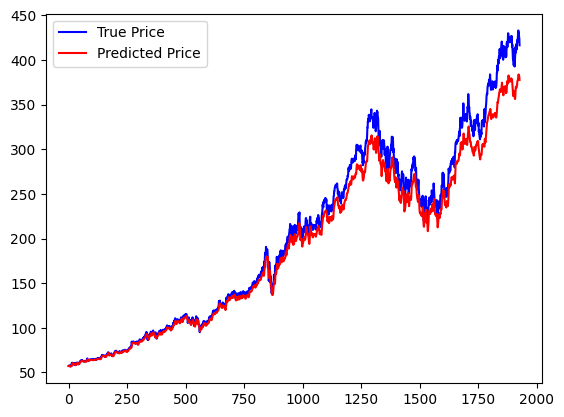

In [22]:
plt.subplot(1,1,1)
plt.plot(Y, label='True Price', color='blue')

plt.subplot(1,1,1)
plt.plot(pred_inv, color='red', label='Predicted Price')

plt.legend()